In [1]:
using PyPlot
using Intervalos

INFO: Loading help data...


#### Las siguientes son Notas sacadas del Capítulo 6 del libro
    
    Validated Numerics: A Short Introduction to Rigorous Computations
    Warwick Tucker

En la sección $6.2$ lo que queremos es resolver el problema de valores iniciales (IVP):
\begin{equation}
    \left\{
        \begin{array}{ll}
            \dot{x}(t)=f(x(t)), \hspace{1cm} t \in [0,T'] \\
            x(0)=x_0.
        \end{array}
    \right.
\end{equation}

Esto implica que 
\begin{equation}
    x(t)=x_0 + \int_0^t f\left(x(s)\right)ds 
\end{equation}


Para lo cual partimos de suponer que conocemos una extensión de intervalo $\Psi$ talque $x(t) \in \Psi(t)$ para toda $t \in [0,T']$. Esto se puede traducir a que:

\begin{equation}
    x(t) \in x_0 + \int_0^t F\left(\Psi(s)\right)ds 
\end{equation}

Donde $F$ es la extensión de intervalo de $f$. Por lo que al final no debemos probar que $x(t) \in \Psi(t)$ sino que

\begin{equation}
    x_0 + \int_0^t F\left(\Psi(s)\right)ds \subseteq \Psi(t) , \hspace{1cm} t \in \left[0,T'\right]
\end{equation}

Cito textualmente:

    "If this condition holds, it follows by Brouwer’s fixed point theorem (Theorem A.12) that the enclosure Ψ(t) contains at least one fixed point of the integral operator (6.6). This means that it indeed encloses at least one solution to the IVP (6.4)."

Por otro lado esta condición tambien implica que $\Psi^{(k+1)} \subseteq \Psi^{(k)}$ donde los ordenes de las $\Psi$'s están dados por:

\begin{align}
    \Psi^{(0)}(t)&=\Psi(t) \\
    \Psi^{(k+1)}(t)&= x_0 + \int_0^t F\left(\Psi^{(k)}(s)\right)ds
\end{align}

En un punto de partida muy sencillo podemos suponer que vamos a tomar intervalos constantes $\Psi^{(k)}(t)=\mathbf{z}^{(k)}$. De modo que las $\mathbf{z}$'s anidadas sean:

\begin{equation}
    \mathbf{z}^{(k+1)}(t)= x_0 + \int_0^t F(\mathbf{z}^{(k)})ds = x_0 + \left[0,T'\right] \times F(\mathbf{z}^{(k)})
\end{equation}

Estos rectángulos son cotas demasiado grandes, podemos reducirlo a triángulos de modo que 

\begin{equation}
    x(t) \in x_0 + t F(\mathbf{z}^{(k)})
\end{equation}

In [2]:
using Images

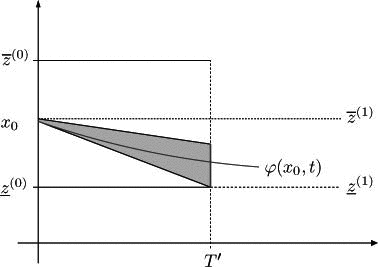

In [2]:
cadena="/home/santiago/Documentos/Libros/Fisica/Métodos Numéricos/Warwick_Tucker_Validated_Numerics_A_Short_IntroBookZZ.org.epub_FILES/OPS/images/f0109-01.jpg"
imread(cadena)

SANTIAGO_001: creé función conosPunto y conosPuntoDiez, que grafica el primer cono

In [6]:
function conosPunto(tI,tF,x0::Intervalo,f::Function,x::Function)
    t=linspace(tI,tF,10)
    PyPlot.plot(t,x(t))
    
    z0=Intervalo[]
    z0Top=similar(t)
    z0Bot=similar(t)
    for i=1:length(t)
        push!(z0,3 + t[i]*f(x0))
        z0Top[i]=z0[i].b
        z0Bot[i]=z0[i].a
        PyPlot.plot(t[i]*[1,1],Float64[z0[i].a,z0[i].b],"--g")
    end
    
    PyPlot.plot(t,z0Top,"-r")
    PyPlot.plot(t,z0Bot,"-r");
    PyPlot.ylim([min(z0Bot[end],z0Bot[1],x(0),x(t[end]))-1,
        max(z0Bot[end],z0Bot[1],x(0),x(t[end]))+1]);
    return z0[end]
end

conosPunto (generic function with 1 method)

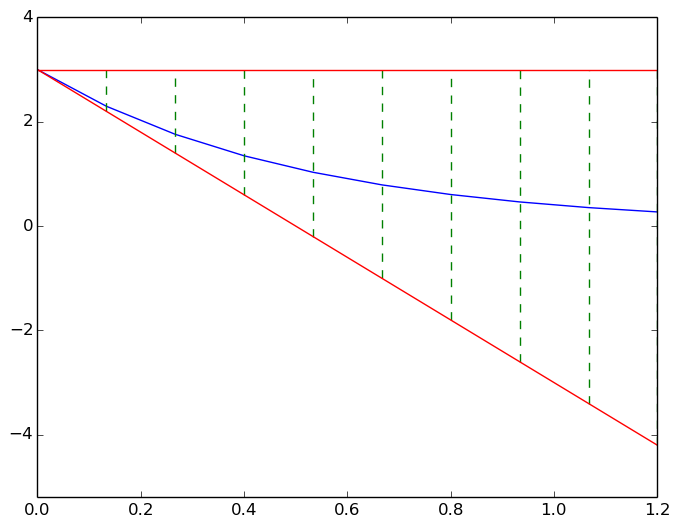

[-4.199999999999999733546474089962430298328399658203125e+00,
3e+00]

In [7]:
# d/dt x(t) = -2x(t) ; x(0)=3   →    x(t)= 3 exp(-2t)
f(x)= -2*x
x(t)=3*exp(-2*t)
conosPunto(0,1.2,Intervalo(0,3),f,x)

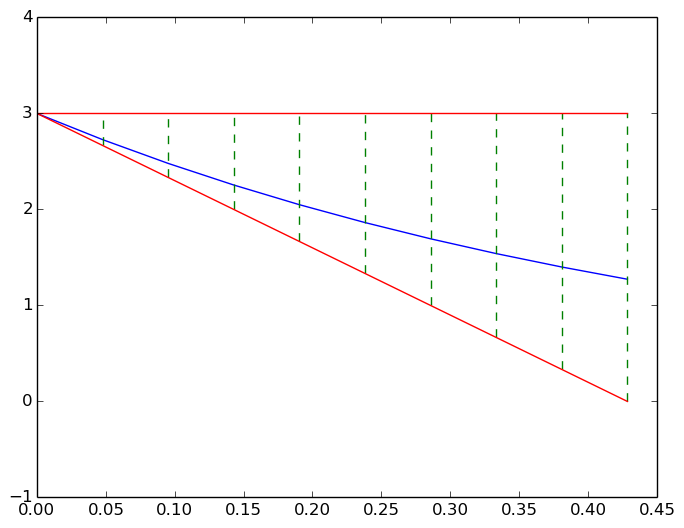

[1.66533453693773481063544750213623046875e-16,
3e+00]

In [8]:
# d/dt x(t) = -2x(t) ; x(0)=3   →    x(t)= 3 exp(-2t)
f(x)= -2*x
x(t)=3*exp(-2*t)
algo1=conosPunto(0,3/7,Intervalo(0,3.5),f,x)

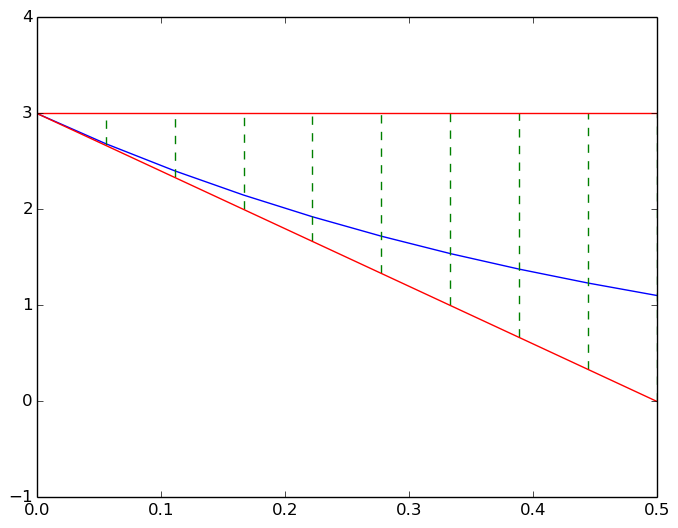

[-0e+00,
3e+00]

In [25]:
# d/dt x(t) = -2x(t) ; x(0)=3   →    x(t)= 3 exp(-2t)
f(x)= -2*x
x(t)=3*exp(-2*t)
conosPunto(0,0.5,Intervalo(0,3),f,x)

Ahora trataré de implementar los 'endpoints'

Primero defino algunas operaciones entre números, arreglos de números, Intervalos y arreglos de Intervalos 

In [6]:
function *(x::Vector{Int64},y::Intervalo)
    z=Intervalo[]
    for i=1:length(x)
        push!(z,x[i]*y)
    end
    return z
end
*(y::Intervalo,x::Vector{Int64})=*(x,y)
function *(x::Vector{Float64},y::Intervalo)
    z=Intervalo[]
    for i=1:length(x)
        push!(z,x[i]*y)
    end
    return z
end
*(y::Intervalo,x::Vector{Float64})=*(x,y)
function +(y::Array{Intervalo,1},x::Number)
    z=similar(y)
    for i=1:length(y)
        z[i]=y[i]+x
    end
    return z
end
+(x::Number,y::Array{Intervalo,1})=+(y,x)

+ (generic function with 185 methods)

Ahora defino funciones que me ayudan a visualizar (y entender) el método

In [7]:
function conosInterv(tI,tF,x0::Intervalo,f::Function,x::Function)
    #t=tI:2.0^-5:tF
    t=linspace(tI,tF,10)
    PyPlot.plot(t,x(t),color="blue")
    
    triple=[tI , t[integer(length(t)/2)] , tF]-tI
    #triplex0=[x0,x0,x0]
    #for i=1:length(temp)
    #    triplex0=triple[i]*x0
    #end
    cono0=x0.a + triple*f(x0)
    cono0Top=Float64[cono0[1].b,cono0[2].b,cono0[3].b]
    cono0Bot=Float64[cono0[1].a,cono0[2].a,cono0[3].a]
    PyPlot.plot(triple+tI,cono0Top,"--",color="red")
    PyPlot.plot(triple+tI,cono0Bot,"-",color="red")
    
    cono1=x0.b + triple*f(x0)
    cono1Top=Float64[cono1[1].b,cono1[2].b,cono1[3].b]
    cono1Bot=Float64[cono1[1].a,cono1[2].a,cono1[3].a]
    PyPlot.plot(triple+tI,cono1Top,"-",color="g")
    PyPlot.plot(triple+tI,cono1Bot,"--",color="g")
    
    PyPlot.ylim([min(cono0Bot[end],cono1Bot[end],cono0Bot[1],cono1Bot[1],x(tI),x(tF))-1,
        max(cono0Bot[end],cono1Bot[end],cono0Bot[1],cono1Bot[1],x(tI),x(tF))+1]);
    
    cono=uneconos(cono0,cono1)
    graficaListaInterv(triple+tI,cono)
    return cono[3]
end

function uneconos(conoA::Array{Intervalo,1},conoB::Array{Intervalo,1})
    # esta función toma dos arreglos de intervalos y los une aunque no se intersecten
    if length(conoA)!=length(conoB)
        error("Deben tener mismo tamaño")
    end
    if conoA[1].a≥conoB[1].a && conoA[end].a≥conoB[end].a
        bajo=conoB
        alto=conoA
    else
        bajo=conoA
        alto=conoB
    end
    cono=Intervalo[]
    for i=1:length(conoA)
        push!(cono,Intervalo((bajo[i]).a,(alto[i]).b))
    end
    return cono
end

function graficaListaInterv(lista::Array{Intervalo,1})
    # esta función grafica una lista de Intervalos
    for i=1:length(lista)
        PyPlot.plot([i,i],Float64[lista[i].a,lista[i].b],"-",color="black")
        #PyPlot.plot([i,i],Float64[lista[i].a,lista[i].b],"-")
    end
    PyPlot.xlim(0,length(lista)+1)
end

function graficaListaInterv(ejeX,lista::Array{Intervalo,1})
    # esta función grafica una lista de Intervalos, con dependencia en x con ejeX
    if length(ejeX)!=length(lista)
        error("Deben tener mismo tamaño")
    end
    for i=1:length(lista)
        PyPlot.plot(ejeX[i]*[1,1],Float64[lista[i].a,lista[i].b],"-",color="black")
        #PyPlot.plot([i,i],Float64[lista[i].a,lista[i].b],"-")
    end
    PyPlot.xlim(0.9*ejeX[1],1.1*ejeX[end])
end

graficaListaInterv (generic function with 2 methods)

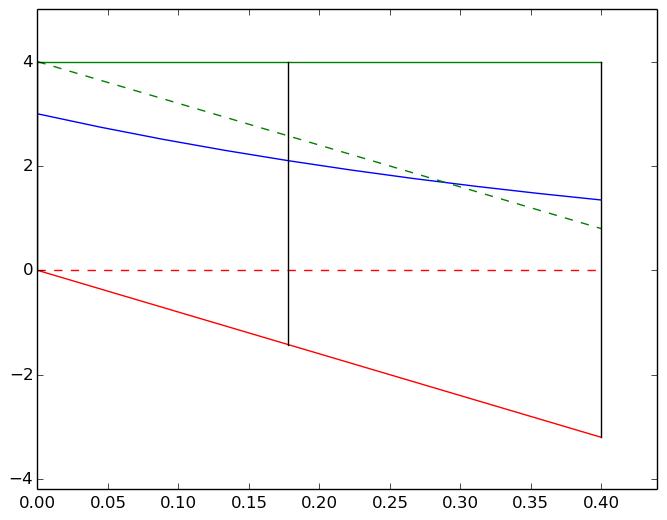

In [8]:
# d/dt x(t) = -2x(t) ; x(0)=3   →    x(t)= 3 exp(-2t)

a0=4
f(x)= -2*x
x(xo,t)=xo*exp(-2*t)
y(t)=x(3,t)

x1=conosInterv(0,0.4,Intervalo(0,4),f,y);

Entonces generé dos conos: conoV (verde) y conoR (rojo), y digo que $x(t)\in$conoV$\cup$conoR. Donde la unión inluye el espacio entre los intervalos, marcado en la gráfica como los intervalos de las líneas continuas (verde y roja). Las lineas negras son los tres intervalos que regresa la función `conosInterv`

Ahora debo aplicar lo de definir un nuevo intervalo para inicar generado por este cono (que será la última línea negra)

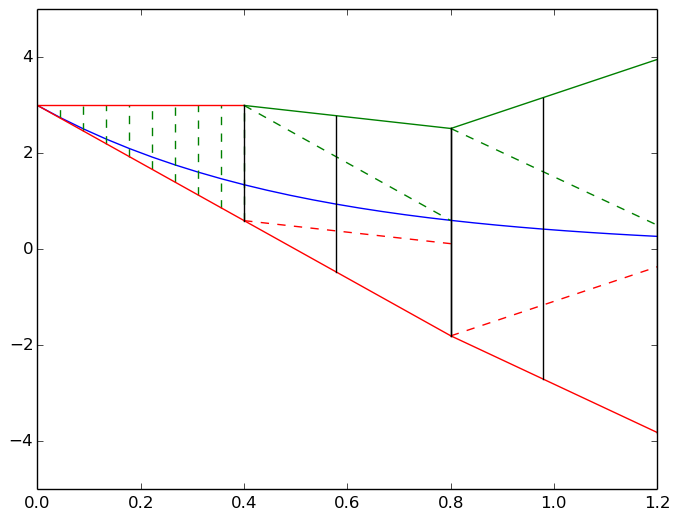

In [9]:
# d/dt x(t) = -2x(t) ; x(0)=3   →    x(t)= 3 exp(-2t)

a0=4
f(x)= -2*x
x(xo,t)=xo*exp(-2*t)
y(t)=x(3,t)

tT=1.2
tiempo=linspace(0,tT,4)

x1=conosPunto(tiempo[1],tiempo[2],Intervalo(0,3),f,y);
#agregué el siguiente renglón
x2=conosInterv(tiempo[2],tiempo[3],x1,f,y);
#agregué el siguiente renglón
conosInterv(tiempo[3],tiempo[4],x2,f,y);
PyPlot.xlim(0,tT)
PyPlot.ylim(-5,5);

Hay algo raro ya que debía disminuir el intervalo, no aumentar, con cada nueva partición. Si no sería mejor tomar una sola partición:

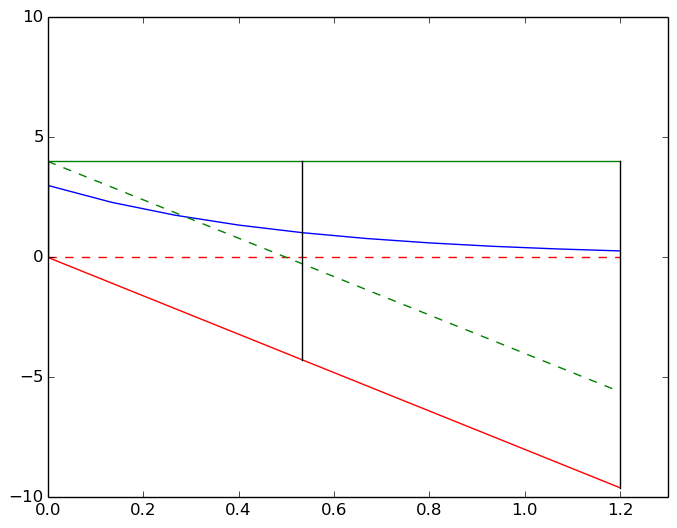

(-10,10)

In [8]:
# d/dt x(t) = -2x(t) ; x(0)=3   →    x(t)= 3 exp(-2t)

a0=4
f(x)= -2*x
x(xo,t)=xo*exp(-2*t)
y(t)=x(3,t)

conosInterv(0,1.2,Intervalo(0,4),f,y)[3];

PyPlot.xlim(0,1.3)
PyPlot.ylim(-10,10);

##Prueba
#t=linspace(0,1.2,10)
#PyPlot.plot(t,x(4,t),color="blue")
#PyPlot.plot(t,x(0,t),color="blue")
##Prueba

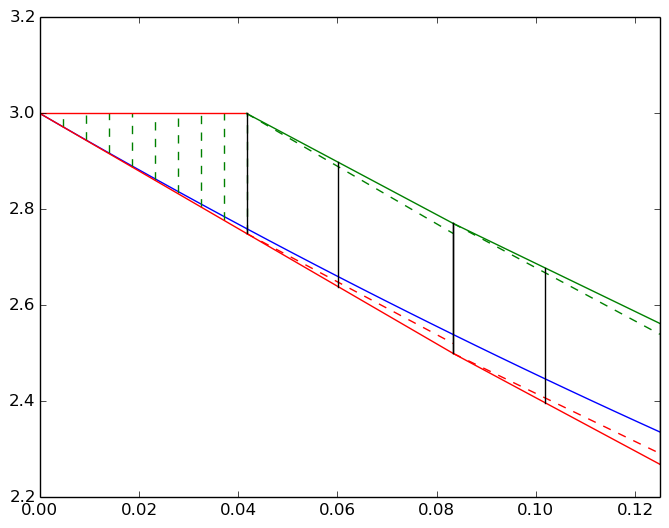

In [14]:
# d/dt x(t) = -2x(t) ; x(0)=3   →    x(t)= 3 exp(-2t)

a0=4
f(x)= -2*x
x(xo,t)=xo*exp(-2*t)
y(t)=x(3,t)

tT=0.125
tiempo=linspace(0,tT,4)

x1=conosPunto(tiempo[1],tiempo[2],Intervalo(0,3),f,y);
#agregué el siguiente renglón
x2=conosInterv(tiempo[2],tiempo[3],x1,f,y);
#agregué el siguiente renglón
x3=conosInterv(tiempo[3],tiempo[4],x2,f,y);
PyPlot.xlim(0,tT)
PyPlot.ylim(2.2,3.2);

In [18]:
x1
x2
#x3

[2.5000000000000000277555756156289135105907917022705078125e+00,
2.770833333333333344898156506512047360277161355520573357074264752830910617936722e+00]

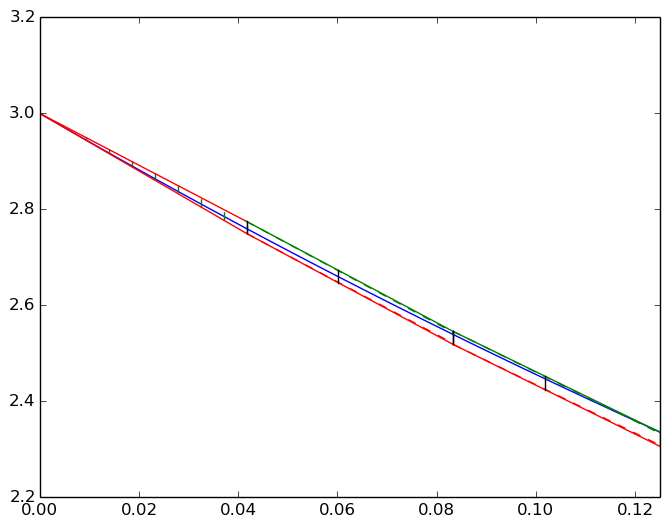

In [13]:
# d/dt x(t) = -2x(t) ; x(0)=3   →    x(t)= 3 exp(-2t)

a0=4
f(x)= -2*x
x(xo,t)=xo*exp(-2*t)
y(t)=x(3,t)

tT=0.125
tiempo=linspace(0,tT,4)

x1=conosPunto(tiempo[1],tiempo[2],Intervalo(2.7,3),f,y);
#agregué el siguiente renglón
x2=conosInterv(tiempo[2],tiempo[3],x1,f,y);
#agregué el siguiente renglón
x3=conosInterv(tiempo[3],tiempo[4],x2,f,y);
PyPlot.xlim(0,tT)
PyPlot.ylim(2.2,3.2);

## A partir de aquí están las funciones que "creo" vamos a usar, las de arriba son solo guía

Santiago_001: Voy a definir las funciones para conocer $Z^k$'s, conociendo tiempo inicial, final, z0 (y # de k's).

También puse un límite para que se detenga si el intervalo ya no se reduce

In [2]:
function zetasKas(tI,tF,x0,z0::Intervalo,f::Function)  
    x0 + Intervalo(tI,tF)*f(z0)
end

function kaesimaZeta(tI,tF,x0,z0::Intervalo,f::Function,k::Int64)
    zetas=[z0]
    for i=1:k
        zk=zetasKas(tI,tF,x0,zetas[i],f)
        if zk==zetas[i]
            return zetas
        else
            push!(zetas,zk)
        end
    end
    return zetas
end

kaesimaZeta (generic function with 1 method)

In [3]:
f(x)=-2x
asdf=kaesimaZeta(0,3/7,3,Intervalo(0,3.5),f,5)

3-element Array{Intervalo,1}:
 [0e+00,
3.5e+00]                                                   
 [1.66533453693773481063544750213623046875e-16,
3e+00]              
 [4.2857142857142871417153173752012662589550018310546875e-01,
3e+00]

Santiago_001: Voy a definir una función que me grafique el cono resultante para 'última' $Z^k$

In [4]:
function graficaCono(tI,tF,x0,zk::Intervalo,col::ASCIIString)
    PyPlot.fill_between([tI,tF],[x0,float64(zk.a)],[x0,float64(zk.b)],color=col)
    #PyPlot.xlim(min(0.9*tI,1.1*tI),max(0.9*tF,1.1*tF))
    #PyPlot.ylim(min(0.9*float64(zk.a),1.1*float64(zk.a)),max(0.9*float64(zk.b),1.1*float64(zk.b)))
    return nothing
end

graficaCono(tI,tF,x0,zk::Intervalo)=graficaCono(tI,tF,x0,zk,"lightblue")

graficaCono (generic function with 2 methods)

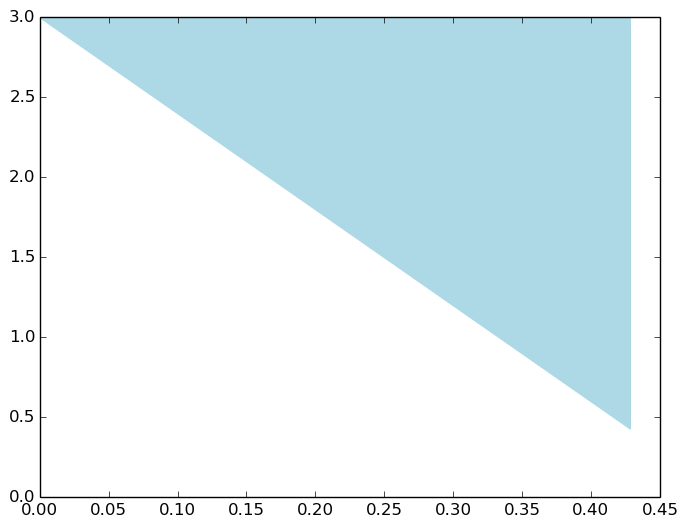

In [5]:
graficaCono(0,3/7,3,asdf[end])

Santiago_002: Defino función que de la envolvente de los conos (iniciar de intervalo en lugar de punto)

In [6]:
function conosInterv(tI,tF,x0::Intervalo,f::Function)
    t=tF-tI
    cono1=x0.a + t*f(x0)    
    cono2=x0.b + t*f(x0)
    conote=uneInterv([cono1],[cono2])
    return conote[1]
end

function uneInterv(conoA::Array{Intervalo,1},conoB::Array{Intervalo,1})
    # esta función toma dos arreglos de intervalos y los une aunque no se intersecten
    if length(conoA)!=length(conoB)
        error("Deben tener mismo tamaño")
    end
    if conoA[1].a≥conoB[1].a && conoA[end].a≥conoB[end].a
        bajo=conoB
        alto=conoA
    else
        bajo=conoA
        alto=conoB
    end
    cono=Intervalo[]
    for i=1:length(conoA)
        push!(cono,Intervalo((bajo[i]).a,(alto[i]).b))
    end
    return cono
end

uneInterv (generic function with 1 method)

Santiago_002: También defino un nuevo método para graficar conos que empiezan en Intervalo en lugar de punto 

In [7]:
function graficaCono(tI,tF,x0::Intervalo,zk::Intervalo,col::ASCIIString)
    PyPlot.fill_between([tI,tF],Float64[x0.a,zk.a],Float64[x0.b,zk.b],color=col)
    PyPlot.plot(tI*[1,1],Float64[x0.a,x0.b],"--",color="black")
    PyPlot.plot(tF*[1,1],Float64[zk.a,zk.b],"--",color="black")
    #PyPlot.xlim(min(0.9*tI,1.1*tI),max(0.9*tF,1.1*tF))
    #PyPlot.ylim(min(0.9*float64(zk.a),1.1*float64(zk.a)),max(0.9*float64(zk.b),1.1*float64(zk.b)))
    return nothing
end

graficaCono(tI,tF,x0::Intervalo,zk::Intervalo)=graficaCono(tI,tF,x0,zk,"lightblue")

graficaCono (generic function with 4 methods)

In [8]:
#Lo siguiente es del módulo RungeKutta de Ernesto
function RungeKutta4(t0::Float64,x0::Float64,h::Float64,n::Integer,f::Function)

    tf=t0+h*n
    t=linspace(t0,tf,n+1)

    x=similar(t); 
    x[1]=x0;


    for i in 2:n+1
        K1=h*f(t[i-1]    ,x[i-1])   
        K2=h*f(t[i-1]+h/2,x[i-1]+K1/2)
        K3=h*f(t[i-1]+h/2,x[i-1]+K2/2)
        K4=h*f(t[i-1]+h  ,x[i-1]+K1)

        x[i]=x[i-1]+(1/6)*(K1+2*K2+2*K3+K4)   #es la expresión general, depende de la función definida abajo
    end 

    return x

end

function zetacero(x0,h,n,F) 
    #hasta ahora siempre t0=0
    t0=0.0;
    x_RK=RungeKutta4(t0,x0,h,n,F);
    zz=Intervalo(minimum(x_RK),maximum(x_RK));

    return(Intervalo(zz.a-0.001*(zz.b-zz.a) , zz.b+0.0001*(zz.b-zz.a)))
end



function BuscarTBuena(x0,h,n,F::Function)    
    tf=n*h;
    z0=zetacero(x0,h,n,F) 

    i=0;
    a=false;
    while a==false
        T=tf-h*i
        z1=x0+Intervalo(0,T)*F(T,z0)
        a=(z1 in z0) #la condición a la que quieras llegar
        i += 1    
    end
    return (tf-h*i)
end

BuscarTBuena (generic function with 1 method)

Santiago_002: Aquí pruebo el método de graficar en un ejemplo que utiliza las funciones que definió Ernesto para calcular `T` y `z0`

In [9]:
# d/dt x(t) = -2x(t) ; x(0)=3   →    x(t)= 3 exp(-2t)

F(t,x)=-2x
t0=0.0;
x0=3.0;
h=0.000015;
n=100000;
tf=t0+h*n;

x_RK=RungeKutta4(t0,x0,h,n,F);
T=BuscarTBuena(x0,h,n,F);
z0=zetacero(x0,h,n,F)

[1.465105663423389485384157577788883183894147263341844813249214015635777177970489e-01,
3.000285063879486279838975665413423332986011341339537267189783719015051379548804e+00]

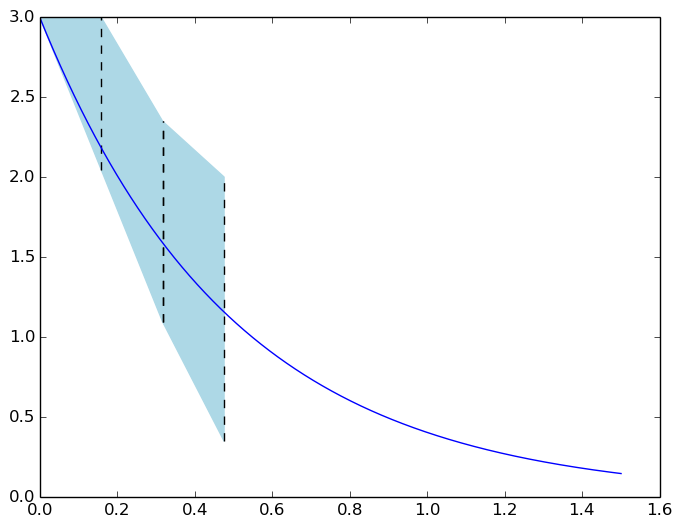

In [10]:
f(x)=F("_",x)
tiempo=linspace(t0,T,4)

x1=zetasKas(tiempo[1],tiempo[2],x0,z0,f)
graficaCono(tiempo[1],tiempo[2],x0,x1)
x2=conosInterv(tiempo[2],tiempo[3],x1,f)
graficaCono(tiempo[2],tiempo[3],x1,x2)
x3=conosInterv(tiempo[3],tiempo[4],x2,f)
graficaCono(tiempo[3],tiempo[4],x2,x3)
PyPlot.plot(linspace(t0,tf,n+1),x_RK,"blue");
#x1=conosPunto(tiempo[1],tiempo[2],Intervalo(0,3),f,y);
#agregué el siguiente renglón
#x2=conosInterv(tiempo[2],tiempo[3],x1,f,y);

Santiago_002: Hice las funciones `envolvente` y `graficaEnvolvente` que calculan y grafican utilizando el método del Tucker, siempre y cuando ya se les den `T` y `z0` (RungeKutta)

In [11]:
function envolvente(tI,tF,x0,z0::Intervalo,f::Function,n::Int64)
    # Esta función hace el cálculo para una z0 dada y partiendo el tiempo en n pedazos    
    envolv=Intervalo[]
    tiempo=linspace(tI,tF,2+n)
    x1=zetasKas(tiempo[1],tiempo[2],x0,z0,f)
    push!(envolv,x1)
    for i=1:n
        #push!(envolv,conosInterv(tiempo[2+n-1],tiempo[2+n],envolv[i],f))
        push!(envolv,conosInterv(tiempo[2+i-1],tiempo[2+i],envolv[i],f))
    end
    return envolv
end

function graficaEnvolvente(tI,tF,x0,envolv::Array{Intervalo,1},col::ASCIIString)
    # Esta función grafica lo que hace la función envolvente
    n=length(envolv)-1
    tiempo=linspace(tI,tF,2+n)
    graficaCono(tiempo[1],tiempo[2],x0,envolv[1],col)
    for i=1:n
        graficaCono(tiempo[1+i],tiempo[2+i],envolv[i],envolv[1+i],col)
    end
    return nothing
end
graficaEnvolvente(tI,tF,x0,envolv::Array{Intervalo,1})=graficaEnvolvente(tI,tF,x0,envolv,"lightblue")

graficaEnvolvente (generic function with 2 methods)

#### Primero comparo con los que calculé 2 In[] arriba

In [12]:
println(x1,"\n",x2,"\n",x3) #estos son los calculados a 'mano'
listaXs=envolvente(t0,T,x0,z0,f,2)

[2.048879631899564345529736240326503278162865825360267313295262635928013625724775e+00,
3e+00]
[1.097849631899564636603567944451544420268922038739173563295262635928013625724775e+00,
2.350484667891519305615366700301913992740226142969964693043158652901792056135186e+00]
[3.527224873312740686290803629583649851546848455969523938097731406061567590674176e-01,
2.002455356083038304798308732439558350171176258128701585618532135970192500847556e+00]


3-element Array{Intervalo,1}:
 [2.048879631899564345529736240326503278162865825360267313295262635928013625724775e+00,
3e+00]                                                                               
 [1.097849631899564636603567944451544420268922038739173563295262635928013625724775e+00,
2.350484667891519305615366700301913992740226142969964693043158652901792056135186e+00]
 [3.527224873312740686290803629583649851546848455969523938097731406061567590674176e-01,
2.002455356083038304798308732439558350171176258128701585618532135970192500847556e+00]

#### Son iguales! Es decir que la función que calcula la envolvente funciona, ahora voy a graficarla para comparar con la gráfica de arriba

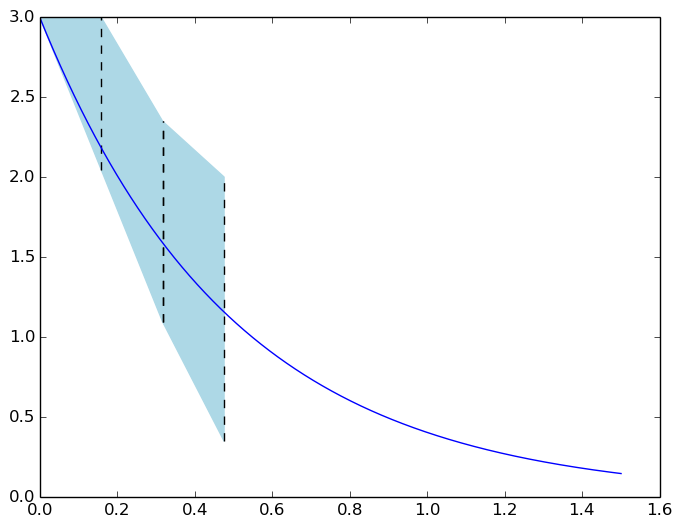

In [13]:
graficaEnvolvente(t0,T,x0,listaXs)
PyPlot.plot(linspace(t0,tf,n+1),x_RK,"blue");

#### También coincide con la de más arriba! Ahora solo falta probarla para muchas particiones:

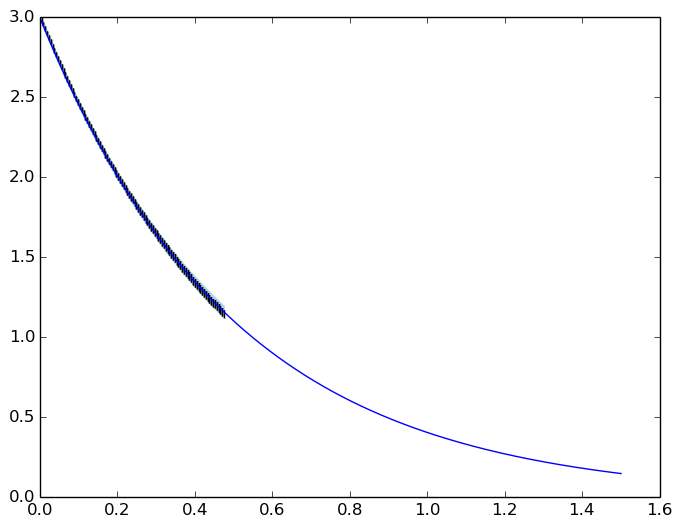

In [14]:
m=100 # Otra vez, m es cuántas veces parto el intervalo (m=0 es un solo cono)
nuevaListaXs=envolvente(t0,T,x0,z0,f,m)
graficaEnvolvente(t0,T,x0,nuevaListaXs)
PyPlot.plot(linspace(t0,tf,n+1),x_RK,"blue");

In [15]:
nuevaListaXs[end]

[1.123241061940131233710892242123638764552264430101928852795167107892909461997245e+00,
1.195361733383562344270736030262694736220542124932618842494715802349783970307609e+00]

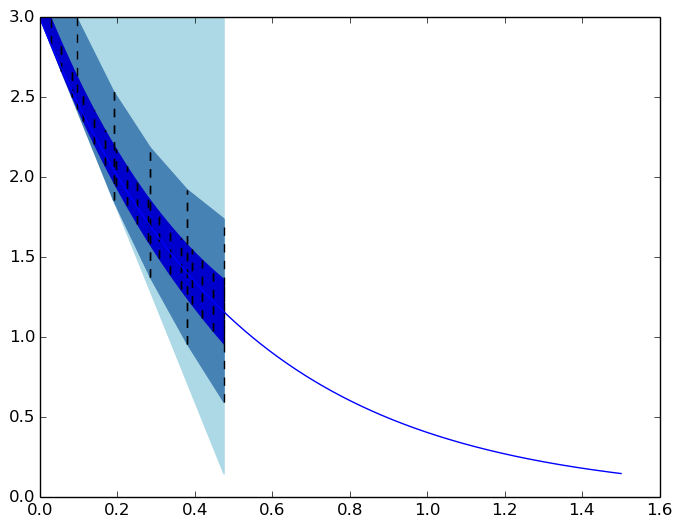

In [16]:
m=0
nuevaListaXs=envolvente(t0,T,x0,z0,f,m)
graficaEnvolvente(t0,T,x0,nuevaListaXs)
m=4
nuevaListaXs=envolvente(t0,T,x0,z0,f,m)
graficaEnvolvente(t0,T,x0,nuevaListaXs,"steelblue")
m=16
nuevaListaXs=envolvente(t0,T,x0,z0,f,m)
graficaEnvolvente(t0,T,x0,nuevaListaXs,"mediumblue")
PyPlot.plot(linspace(t0,tf,n+1),x_RK,"blue");
# para ver colores disponibles en PyPlot ver 'http://matplotlib.org/examples/color/named_colors.html';

# A continuación hay ejemplos para el módulo completo

In [1]:
using RungeKutta, PrimerOrden

INFO: Loading help data...


In [2]:
using Intervalos, PyPlot

In [3]:
f(x)=-2x
f(t,x)=-2x
x0=3.0
t0=0.0
tf=1.5
n=1024
dt=tf/n
ordenka=200
pasosdeintegracion=30;

In [4]:
x_RK=RungeKutta4(t0,x0,dt,n,f);
eul=NEulerMPasos(f,x0,t0,n,dt,ordenka,pasosdeintegracion);

el número máximo alcanzado con intervalos es: 1.2275390625 de 1.5


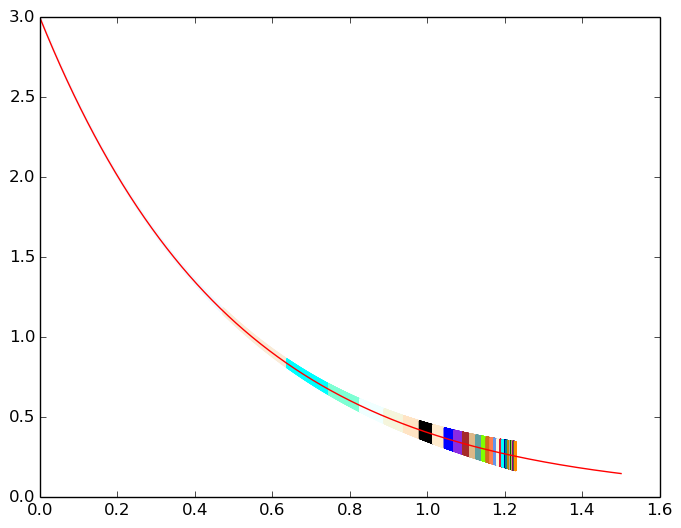

In [5]:
graficarEulerM(eul[1],eul[2],eul[3],x_RK,t0,tf,n,dt,pasosdeintegracion)

#### Prueba rápida con x0 Intervalo

In [6]:
x_RK=RungeKutta4(t0,x0,dt,n,f);
eul=NEulerMPasos(f,Intervalo(x0),t0,n,dt,ordenka,pasosdeintegracion);

el número máximo alcanzado con intervalos es: 1.2275390625 de 1.5


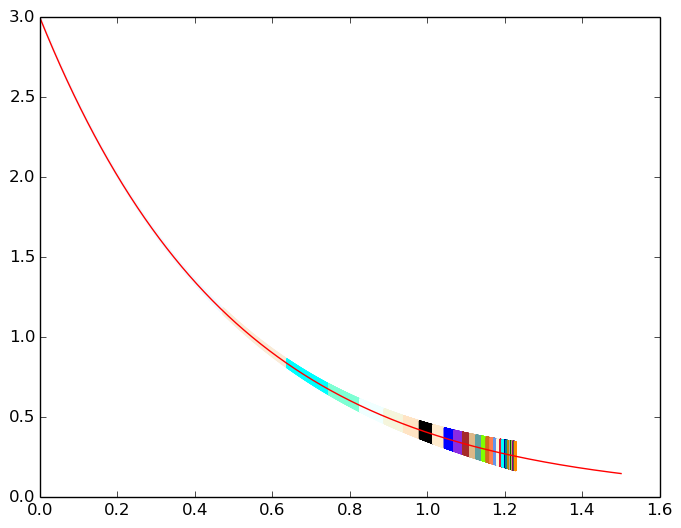

In [7]:
graficarEulerM(eul[1],eul[2],eul[3],x_RK,t0,tf,n,dt,pasosdeintegracion)

In [6]:
f(x)=8x
f(t,x)=8x
x0=3.0
t0=0.0
tf=1.5
n=1024
dt=tf/n
ordenka=200
pasosdeintegracion=30;

In [7]:
x_RK=RungeKutta4(t0,x0,dt,n,f);
eul=NEulerMPasos(f,x0,t0,n,dt,ordenka,pasosdeintegracion);

el número máximo alcanzado con intervalos es: 0.9140625 de 1.5


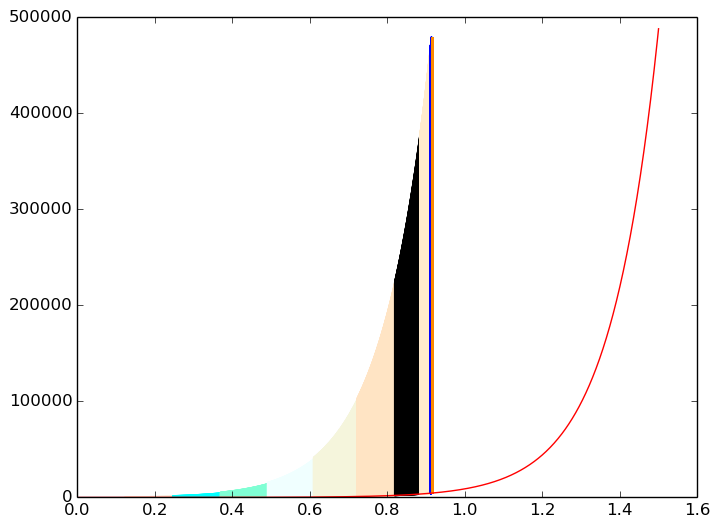

In [8]:
graficarEulerM(eul[1],eul[2],eul[3],x_RK,t0,tf,n,dt,pasosdeintegracion)

In [9]:
println(3*e^12)
eul[3][end][end]


488264.37425701175


[4.267219276725916703093020580155583764866691397368225162505177406016070871772138e+03,
4.797622764481159461272887754591532073621793399333774657732799724578257472547088e+05]

In [10]:
f(x)=-2*x*exp(-x^2) #solución: gaussiana NOO
f(t,x)=-2*x*exp(-x^2)
x0=1.0
t0=0.0
tf=1.5
n=1024
dt=tf/n
ordenka=200
pasosdeintegracion=30;

In [11]:
x_RK=RungeKutta4(t0,x0,dt,n,f);
eul=NEulerMPasos(f,x0,t0,n,dt,ordenka,pasosdeintegracion);

el número máximo alcanzado con intervalos es: 1.283203125 de 1.5


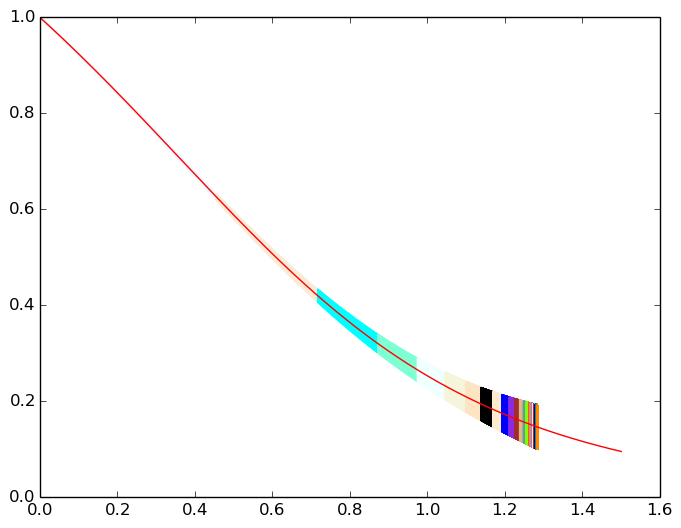

In [12]:
graficarEulerM(eul[1],eul[2],eul[3],x_RK,t0,tf,n,dt,pasosdeintegracion)

In [13]:
f(x)=-x^2 
f(t,x)=-x^2
x0=1.0
t0=0.0
tf=1.5
n=1024
dt=tf/n
ordenka=200
pasosdeintegracion=30;

In [14]:
x_RK=RungeKutta4(t0,x0,dt,n,f);
eul=NEulerMPasos(f,x0,t0,n,dt,ordenka,pasosdeintegracion);

el número máximo alcanzado con intervalos es: 1.4296875 de 1.5


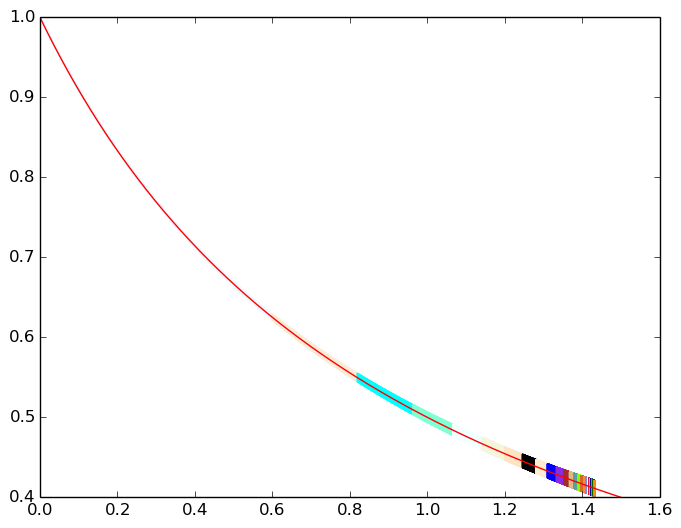

In [15]:
graficarEulerM(eul[1],eul[2],eul[3],x_RK,t0,tf,n,dt,pasosdeintegracion)

In [39]:
using FactCheck

In [296]:
facts("Probando funciones para intervalos anidados")do
    f(x)=-2x
    t0=0;tf=1.5;
    x0=3.0;z0=Intervalo(0,3);
    
    #función zetasKas
    @fact zetasKas(t0,tf,x0,z0,f) => Intervalo("-6",3)
    tf=0.5
    @fact zetasKas(tf,t0,x0,z0,f) => Intervalo(0,3.0)
    
    #función kaesimaZeta
    @fact kaesimaZeta(t0,tf,x0,z0,f,1) => [Intervalo(0,3)]
    @fact kaesimaZeta(t0,tf,x0,z0,f,10) => [Intervalo(0,3)]
    tf=0.4
    z0=Intervalo(0,3.5);
    @fact length(kaesimaZeta(t0,tf,x0,z0,f,13)) => 3
    @fact in(kaesimaZeta(t0,tf,x0,z0,f,10)[2],kaesimaZeta(t0,tf,x0,z0,f,10)[1]) => true
    @fact in(kaesimaZeta(t0,tf,x0,z0,f,10)[3],kaesimaZeta(t0,tf,x0,z0,f,10)[2]) => true
    
    #función uneInterv
    interv1=Intervalo("0.1")
    interv2=Intervalo("5.1",100000)
    interv3=Intervalo("3.1","10.1")
    @fact uneInterv([interv1,interv1],[interv2,interv3])[1] => Intervalo(interv1.a,interv2.b)
    @fact uneInterv([interv1,interv1],[interv2,interv3])[2] => Intervalo(interv1.a,interv3.b)
    
    #función conosInterv
    tf=2.0^-3; z0=Intervalo(0.5,3);
    @fact conosInterv(tf,2*tf,zetasKas(t0,tf,x0,z0,f),f) => Intervalo(1.5,2+2.0^-2+2.0^-3+2.0^-4)
end;


facts("Probando RungeKutta")do
    f(x)=-2x
    f(t,x)=-2x
    x0=3.0
    t0=0.0
    tf=1.5 #notese que 1.5=2.0^0+2.0^-1 (exactamente representable)
    n=1024 #notese que 1.5=2.0^0+2.0^-1 (exactamente representable)
    dt=tf/n
    ka=200
    pasosExtra=30;
    x_RK=RungeKutta4(t0,x0,dt,n,f)
    @fact length(x_RK) => n+1
    @fact in(Intervalo(maximum(x_RK),minimum(x_RK)),zetacero(x0,dt,n,f)) => true
    @fact BuscarTBuena(x0,dt,n,f) => less_than(tf)
    @fact BuscarTBuena(x0,dt,n,f) => greater_than(t0)
    @fact x_RK[end]-(3*exp(-2*tf)) => less_than(2.0^-5)
end;

facts("Probando función envolvente")do
    f(x)=-2x
    f(t,x)=-2x
    x0=3.0
    t0=0.0
    tf=1.5 #notese que 1.5=2.0^0+2.0^-1 (exactamente representable)
    n=1024 
    dt=tf/n #notese que 1024=2.0^10 por lo que dt=2.0^-10+2.0^-11 (exactamente representable)
    ka=200
    pasosExtra=30;
    x_RK=RungeKutta4(t0,x0,dt,n,f);
    z0=zetacero(x0,dt,n,f)
    T=BuscarTBuena(x0,dt,n,f)
    envi0=envolvente(t0,T,x0,z0,f,0);
    envi30=envolvente(t0,T,x0,z0,f,30);
    @fact length(envi0) => 1
    @fact length(envi30) => 31
    @fact in(envi30[end],envi0[end]) => true
    @fact in(x_RK[1],envi30[1]) => true
    @fact in(x_RK[T/dt],envi30[end]) => true #notese que T/dt es entero ya que dt es exactamente representable
end;

facts("Probando función NEulerMPasos")do
    t0=0.0
    tf=1.5
    n=1024
    dt=tf/n
    ordenka=200
    pasosdeintegracion=30;
    # Voy a probar algunas ODE cuya solución conozco
    
    f(x)=-2x  # solución x(t)=x0 exp(-2t)
    f(t,x)=-2x
    x0=3.0       
    eul=NEulerMPasos(f,x0,t0,n,dt,ordenka,pasosdeintegracion);
    for i=1:5
        n=int((2*rand()+1)*pasosdeintegracion/3) #paso de integración aleatorio (mayor que (1/3)pasosdeintegracion)
        @fact in(x0*exp(-2*eul[1][n])  ,  eul[3][n][1]) => true 
        # eul[1][n] es el tiempo en el n-ésimo paso de integración
        # eul[3][n][1] es la solución (primer valor de la subpartición del n_ésimo paso de integración)
    end
    
    f(x)=x  # solución x(t)=x0 exp(t)
    f(t,x)=x
    x0=Intervalo("1.1") #pruebo con condición inicial no representable
    eul=NEulerMPasos(f,x0,t0,n,dt,ordenka,pasosdeintegracion);
    for i=1:5
        n=int((2*rand()+1)*pasosdeintegracion/3) #paso de integración aleatorio (mayor que (1/3)pasosdeintegracion)
        @fact in(x0.a*exp(eul[1][n])  ,  eul[3][n][1]) => true 
        # eul[1][n] es el tiempo en el n-ésimo paso de integración
        # eul[3][n][1] es la solución (primer valor de la subpartición del n_ésimo paso de integración)
    end
     
    f(x)=-x^2  # solución x(t)=1/(t+1/x0)
    f(t,x)=-x^2
    x0=2.0
    eul=NEulerMPasos(f,x0,t0,n,dt,ordenka,pasosdeintegracion);
    for i=1:5
        n=int((2*rand()+1)*pasosdeintegracion/3) #paso de integración aleatorio (mayor que (1/3)pasosdeintegracion)
        @fact in(1/(eul[1][n]+1/x0)  ,  eul[3][n][1]) => true 
        # eul[1][n] es el tiempo en el n-ésimo paso de integración
        # eul[3][n][1] es la solución (primer valor de la subpartición del n_ésimo paso de integración)
    end
end;


Probando funciones para intervalos anidados
10 facts verified.
Probando RungeKutta
5 facts verified.
Probando función envolvente
5 facts verified.
Probando función NEulerMPasos
15 facts verified.


In [293]:
f(x)=-x^2
f(t,x)=-x^2
x0=2.0
t0=0.0
tf=1.5
n=1024
dt=tf/n
ordenka=200
pasosdeintegracion=30;
#x_RK=RungeKutta4(t0,x0,dt,n,f);
#z0=zetacero(x0,dt,n,f)
#T=BuscarTBuena(x0,dt,n,f)
#envi=envolvente(t0,T,x0,z0,f,30);
#PyPlot.plot(linspace(t0,tf,n+1),x_RK)
#T=dt*323
eul=NEulerMPasos(f,x0,t0,n,dt,ordenka,pasosdeintegracion);

In [37]:
in(x0*exp(-2*eul[1][8])  ,  eul[3][8][1]) # eul[1][n] es el tiempo en el n-ésimo paso de integración
# eul[3][n][1] es la solución (primer valor de la subpartición del n_ésimo paso de integración)

true

In [294]:
for i=1:30
    !in(1/(eul[1][i]+1/x0)  ,  eul[3][i][1]) && println(i)
end

1
2
3
4
5
6


el número máximo alcanzado con intervalos es: 1.0576171875 de 1.5


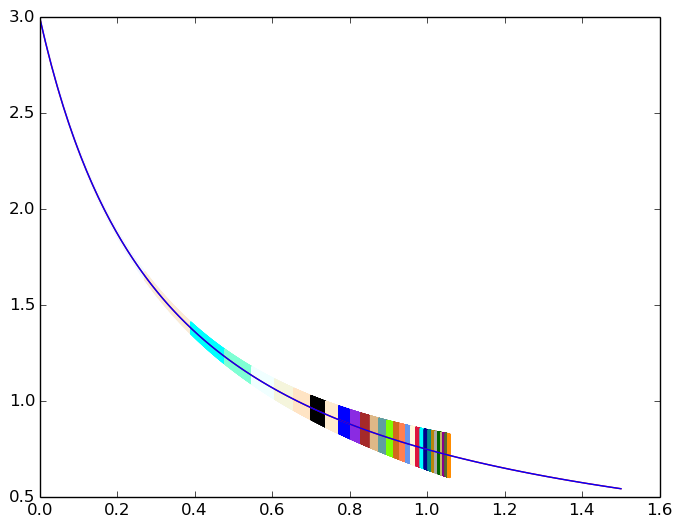

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f5cc2b6c410>

In [290]:
x_RK=RungeKutta4(t0,x0,dt,n,f);
graficarEulerM(eul[1],eul[2],eul[3],x_RK,t0,tf,n,dt,pasosdeintegracion)
xx=linspace(0,1.5)
PyPlot.plot(xx,1./(xx+1/x0))

Falta:

    Hacer que los pasos de tiempo sean potencias de 2

    Seleccionar paso de integración tal que KT<1

    Usar Serie de Taylor para órdenes superiores

Primero voy a hacer una función que regrese algo parecido a `tiempo=linspace(tI,tF,n)` pero con pasos que sean potencias de dos

In [17]:
function parteTiempo(ti,tf,n::Integer)
    linspace(ti,tf,n)
end

parteTiempo(1,10,10)

10-element Array{Float64,1}:
  1.0
  2.0
  3.0
  4.0
  5.0
  6.0
  7.0
  8.0
  9.0
 10.0

In [18]:
#estas funciones básicas las defino para que verifique que los pasos de tiempo en parteTiempo no sean despreciables

function bin_a_10(y::ASCIIString) #esta función toma una cadena de 1's y 0's y la transforma en un entero base 10
    if y[1]=='-' #este if lo puse para incluir números negativos
        x=y[2:length(y)]
        b=-1
    else
        x=y
        b=1
    end
    a=0
    for i=0:length(x)-1
        if x[i+1]!='0' && x[i+1]!='1'
            error("Debe ser cadena de 0's y 1's")
        else
            if x[i+1]=='1'
                a=a+2^(length(x)-i-1)
            end
        end
    end
    b*a
end
function distancia_normales(e::Int64) #esta función pide la potencia de 2 'e' y la long de la mantissa 'p'
    #y te devuelve la distancia entre numeros normales concecutivos para esa potencia
    if 52-1-e >= 0
        a="0."*repeat("0",52-1-e)*"1" #donde e es la potencia de β
    else
        a="1"*repeat("0",e-52)*".0"
    end
    bin_a_10_con_punto(a)
end

distancia_normales (generic function with 1 method)

In [19]:
bits(10.0)
bin_a_10(bits(10.0)[2:12])-1023

3

In [20]:
log2(10)

3.321928094887362

In [21]:
function zetaCeroBurdo(ti,tf,x0,f::Function)
    # Función que usa RungeKutta para encontrar un z0 con cual iniciar
    f(t,x)=f(x)    
    t=linspace(t0,tf)
    h=t[2]-t[1]
    x=similar(t); 
    x[1]=x0;
    for i=2:100
        K1=h*f(t[i-1]    ,x[i-1])   
        K2=h*f(t[i-1]+h/2,x[i-1]+K1/2)
        K3=h*f(t[i-1]+h/2,x[i-1]+K2/2)
        K4=h*f(t[i-1]+h  ,x[i-1]+K1)

        x[i]=x[i-1]+(1/6)*(K1+2*K2+2*K3+K4)   #es la expresión general, depende de la función definida abajo
    end 
    zz=Intervalo(minimum(x),maximum(x));
    return (Intervalo(zz.a-(2.0^-12)*(zz.b-zz.a) , zz.b+(2.0^-12)*(zz.b-zz.a)))
end

zetaCeroBurdo(0,1.5,3,f)

[1.487000721699115369879898827798481164563781931065022945404052734375e-01,
3.0006959482372052937424974396185550773452632711268961429595947265625e+00]

In [22]:
function compruebaT(pasoT,x0,z0::Intervalo,f::Function)
    # Esta función comprueba que se cumpla Lipschitz para la función 'f' en el intervalo temporal [ti,tf]
    # partiendo de la condición inicial x0 con un intervalo z0
    z1=x0+Intervalo(0,pasoT)*f(z0)
    z1 in z0 #la condición a la que quieras llegar
end
!compruebaT(1.4,3,Intervalo(0,3),f)
compruebaT(1.4,3,Intervalo(0,3),f)

false

In [23]:
function primerOrdenAux(tI,tF,x0,z0::Intervalo,f::Function,n::Int64)
    # Esta función hace el cálculo para una z0 dada y partiendo el tiempo en n pedazos (buenos)
    # y comprobando a cada paso que se cumpla Lipschitz
    envolv=Intervalo[]
    tiempo=linspace(tI,tF,2+n)
    if !compruebaT(tiempo[2]-tiempo[1],x0,z0,f)
        return -1
    end
    x1=zetasKas(tiempo[1],tiempo[2],x0,z0,f)
    push!(envolv,x1)
    for i=1:n
        # Para cada nuevo paso, tengo que comprobar que la función cumpla Lipschitz para cada extremo del intervalo
        z0_1=zetaCeroBurdo(tiempo[2+i-1],tiempo[2+i],envolv[i].a,f)
        z0_2=zetaCeroBurdo(tiempo[2+i-1],tiempo[2+i],envolv[i].b,f)
        ti=tiempo[2+n]-tiempo[2+n-1]
        if !compruebaT(ti,envolv[i].a,z0_1,f) || !compruebaT(ti,envolv[i].b,z0_2,f)
            return -2
        end
        #println(zetasKas(tiempo[2+i-1],tiempo[2+i],envolv[i].a,z0_1,f))
        #push!(envolv,conosInterv(tiempo[2+n-1],tiempo[2+n],envolv[i],f))
        push!(envolv,conosInterv(tiempo[2+i-1],tiempo[2+i],envolv[i],f))
    end
    return envolv
end

f(x)=-2x
z0=zetaCeroBurdo(0,1.5,3,f)
listaTemp=primerOrdenAux(0,1.4,3,z0,f,1000);

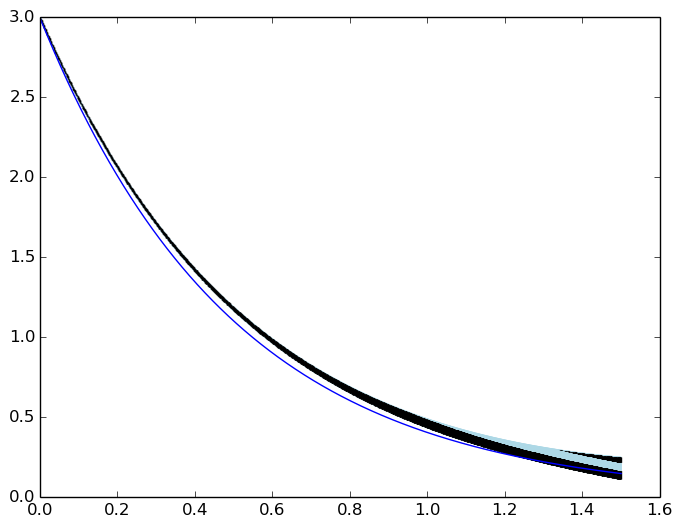

In [24]:
graficaEnvolvente(0,1.5,3,listaTemp)
PyPlot.plot(linspace(t0,tf,n+1),x_RK,"blue");

In [3]:
# Basado en función BuscarTBuena voy a hacer una función que en vez de buscarla, compruebe si T es buena
function compruebaTBuena(x0,ti,tf,f::Function,z0::Intervalo)    
    z1=x0+Intervalo(ti,tf)*f(z0)
    return (z1 in z0)
end
#function BuscarTBuena(x0,h,n,F::Function)    
    #Esta función busca el t que hace que la ecuación 6.9 
    #del Tucker se cumpla para Psi=z0.
    #El z0 que usamos es uno que engloba la solución hasta tf 
    #y se obtiene con  Runge Kutta a 4 orden
#        tf=n*h;
#        z0=zetacero(x0,h,n,F) 
#        
#        i=0;
#        a=false;
#        while a==false
#            T=tf-h*i
#            z1=x0+Intervalo(0,T)*F(T,z0)
#            a=(z1 in z0) #la condición a la que quieras llegar
#            i += 1    
#        end
#        return (tf-h*i)
#end

compruebaTBuena (generic function with 1 method)

In [4]:
f(x)=-2x
f(t,x)=-2x
x0=3.0
t0=0.0
tf=1.5
n=1024
dt=tf/n
ordenka=200
pasosdeintegracion=30;

z0=zetacero(x0,dt,n,f)
BuscarTBuena(x0,dt,n,f)

0.47314453125

In [5]:
comp=compruebaTBuena(x0,0,tf,f,z0)
ai=0
while comp==false
    ai+=1
    tt=tf*2.0^-ai
    println(ai)
    comp=compruebaTBuena(x0,0,tt,f,z0)
end
tf*2.0^-ai

1
2


0.375

Entonces compruebaTBuena solo se hizo true hasta que su 3er argumento fue menor que el resultado de BuscarTBuena

In [6]:
tf=1.5
n=0
dt=tf/2^n
zetacero(x0,dt,2^n,f)

[7.4774999999999999995316246614862620845087803900241851806640625e-01,
3.00225000000000000004683753385137379154912196099758148193359375e+00]

In [7]:
function primerOrdenHastaNAux(ti,tf,x0,z0::Intervalo,f::Function,ordenK)
    if !compruebaTBuena(x0,ti,tf,f,z0)
        return -1
    end
    z_k0=kaesimaZeta(ti,tf,x0,z0,f,ordenK)[end]
    return z_k0
    ###si quiero partir cada paso en subpasos (sin control en si t es representable en subpasos)###
    #nuevaListaXs=envolvente(t0,tf,x0,z_k0,f,ordenK)
    #return nuevaListaXs
    
end

primerOrdenHastaNAux (generic function with 1 method)

In [8]:
f(x)=-2x
f(t,x)=-2x
x0=3.0
t0=0.0
tf=1.5
#n=1024
#dt=tf/n

pasosdeintegracion=30;

n=2
ordenka=3
#tiempo=linspace(ti,tf,1+2^n)
dt=(tf-t0)/2^n
z0=zetacero(x0,dt,2^n,f)
algo=primerOrdenHastaNAux(t0,t0+dt,x0,z0,f,ordenka)

[7.5e-01,
3e+00]

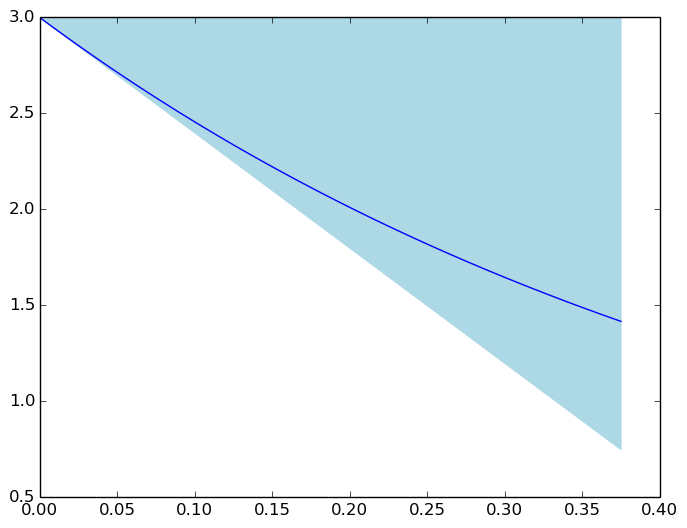

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f33805598d0>

In [9]:
graficaEnvolvente(t0,t0+dt,x0,[algo])
xx=linspace(t0,t0+dt)
PyPlot.plot(xx,x0*exp(-2xx))

In [49]:
#Ahora trabajo con los siguientes pasos

function primerOrdenHastaN(ti,tf,x0,f::Function,ordenK,mOrden::Int64)
    # El numero de particiones es (2^m)-1 donde m=mOrden
    if ti!=0 && tf+ti==tf
        error("Quieres cubrir demasiado tiempo")
    end
    envol=Intervalo[]
    n=mOrden
    dt=(tf-ti)/2^n
    z0=zetacero(x0,dt,2^n,f)
    z1=primerOrdenHastaNAux(ti,ti+dt,x0,z0,f,ordenka)
    if z1==-1
        return [Intervalo(-inf(BigFloat),inf(BigFloat))]
        #regreso el máximo intervalo posible para pasar a la siguiente opción de partición
    end
    push!(envol,z1)
    #Si z1 no fue -1 entonces hay que ver si esta partición es buena en los siguientes pasos
    for i=2:2^n
        tiemIn=ti+dt*(i-1)
        tiemFin=ti+dt*i
        z2=primerOrdenHastaNAux2(tiemIn,tiemFin,envol[i-1],z0,f,ordenka)
        if z2==-1
            return [Intervalo(0,inf(BigFloat))]
            #regreso el máximo intervalo posible para pasar a la siguiente opción de partición
        end
        println(tiemIn)
        push!(envol,z2)
    end
    return envol
end


function primerOrdenHastaNAux2(ti,tf,x0::Intervalo,z0::Intervalo,f::Function,ordenK)
    if !compruebaTBuena(x0,0,tf-ti,f,z0)
        return -1
    end
    #z_k0=kaesimaZeta(ti,tf,x0,z0,f,ordenK)[end]
    z_k=conosInterv(ti,tf,x0::Intervalo,f::Function,z0)#z_k0)
    return z_k
end

function conosInterv(tI,tF,x0::Intervalo,f::Function,z0::Intervalo)
    t=tF-tI
    cono1=x0.a + t*f(z0)    
    cono2=x0.b + t*f(z0)
    conote=uneInterv([cono1],[cono2])
    return conote[1]
end

conosInterv (generic function with 1 method)

In [ ]:
f(x)=-2x
f(t,x)=-2x
x0=3.0
t0=0.0
tf=1.5

nFinal=4
ordenka=3
primerOrdenHastaN(t0,tf,x0,f,ordenka,nFinal)

In [48]:
#para nFinal=4

z1=Intervalo(1.853631061159273124948990037737374226993895184226868421334395462995702223880923e-01,
            2.889030777956760148123057386023008075033965050058758470366560453700429777611908e+00)
tin=0.375
tfi=0.75
z0=Intervalo(1.788906415540259330878092774848601541743785038618159283219100075257301796227694e-01,
    3.002818291067378595530049609233889845825621496138184071678089992474269820377231e+00)

primerOrdenHastaNAux2(tin,tfi,z1,z0,f,ordenka)

compruebaTBuena(z1,0,tfi-tin,f,z0)
z1+Intervalo(0,tfi-tin)*f(z0)

[-2.0667506121846066502456551461364142596721649169921875e+00,
2.8890307779567603319037516484968364238739013671875e+00]

In [39]:
#para nFinal=2

z1=Intervalo(7.5e-01,3e+00)
tin=0.375
tfi=0.75
z0=Intervalo(1.788906415540259330878092774848601541743785038618159283219100075257301796227694e-01,
    3.002818291067378595530049609233889845825621496138184071678089992474269820377231e+00)

primerOrdenHastaNAux2(tin,tfi,z1,z0,f,ordenka)

compruebaTBuena(z1,0,tfi-tin,f,z0)
z1+Intervalo(0,tfi-tin)*f(z0)

[-1.5021137183005339732488891968387179076671600341796875e+00,
3e+00]

In [58]:
#función para obtener anchos de intervalos
anchoInterv(x::Intervalo)=x.b-x.a

function primerOrden(ti,tf,x0,f::Function,ordenK,precision,nMax)
    n=0
    while n<nMax && anchoInterv(z_esima[end])>precision
        z_esima=primerOrdenHastaN(ti,tf,x0,f::Function,ordenK,n)
        n+=1
    end
    if n==nMax
        error("No pude obtener esa presición")
    end
    return z_esima
end

primerOrden (generic function with 1 method)

In [ ]:
f(x)=-2x
f(t,x)=-2x
x0=3.0
t0=0.0
tf=1.5
#n=1024
#dt=tf/n

#pasosdeintegracion=30;

n=2
ordenka=3
#tiempo=linspace(ti,tf,1+2^n)
dt=(tf-t0)/2^n
z0=zetacero(x0,dt,2^n,f)

precision=0.5
nMax=100
primerOrden(t0,tf,x0,f,ordenka,precision,nMax)